# RPM Time Series Subtyping

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama

In [2]:
adata = cr.read('../../out/RPM-time-series/adata_02.h5ad')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


In [3]:
X_magic = cr.read('../../out/RPM-time-series/X_magic_02.h5ad')
X_magic

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'neighbors', 'pca', 'specialists_pca_diffdist_colors', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'arc_distance', 'py_pcha_S'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.layers['imputed'] = X_magic.X
adata.obsm['X_pca_imputed'] = X_magic.obsm['X_pca']

In [5]:
adata.write_h5ad('../../out/RPM-time-series/adata_03.h5ad')

# Subtyping with Archetype Signatures on Adata

In [9]:
adata = cr.read('../../out/RPM-time-series/adata_03.h5ad')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


## Using Mazebox to generate archetype scores

In [10]:
sig_matrix = pd.read_csv('../../out/bulk/sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
sig_matrix.index = [i.capitalize() for i in sig_matrix.index]

In [7]:
# import seaborn as sns
# max_subtype = []
# max_v = []
# sig_matrix_copy = sig_matrix.copy()
# for i,r in sig_matrix.iterrows():
#     maxi = r.idxmax()
#     maxv = r.max()
#     max_subtype.append(maxi) 
#     max_v.append(maxv)
# sig_matrix_copy['max_subtype'] = max_subtype
# sig_matrix_copy['max'] = max_v

# plt.figure(figsize=(5,30))
# sig_matrix_copy = sig_matrix_copy.sort_values(by = ['max_subtype','max'], ascending=[True, False])
# sig_matrix_copy = sig_matrix_copy[['SCLC-A','SCLC-A2','SCLC-N','SCLC-P','SCLC-Y']]
# sns.heatmap(sig_matrix_copy, cmap='viridis', yticklabels = True)
# plt.xticks(rotation = 90)
# plt.title(f'Log-transformed Archetype Expression Profiles')
# plt.tight_layout()
# # plt.savefig(op.join(outdir,f'figures/Archetypes/sig_matrix_logfc.pdf'))
# plt.show()
# plt.close()

# sig_matrix_copy.to_csv('../data/sig_matrix_ParTI.csv')

If the below code gives an error about data shape, use `type = 'csr'`.

Cells with zero expression for all genes in gene signature will get scores of NaN when assigning scores in adata.obs (because these cells are filtered for the calculation). 

Trying to set attribute `.obs` of view, copying.


Transforming tumor data...
Gene signature matrix now has shape:  (85, 5)
Tumor data shortened to genes in gene list...
(15138, 85)
Tumor data subsetting complete.


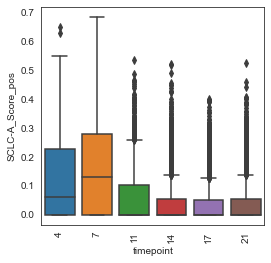

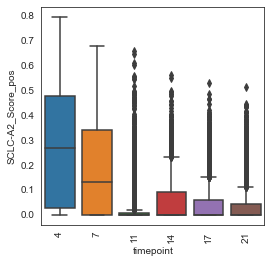

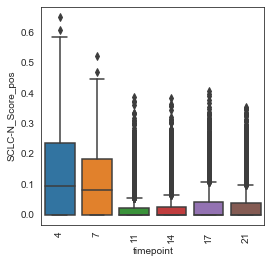

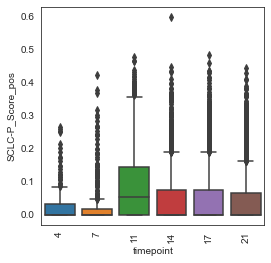

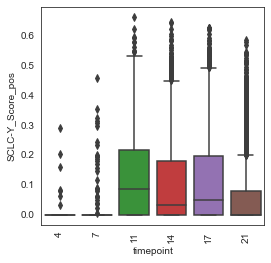

In [12]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'timepoint',velocity=False)


In [13]:
from sklearn.manifold import LocallyLinearEmbedding
def _archetype_diagram_no_arrows(_adata, score_name, color, figsize, order, multiplier,fname,
                                 sizes = None, alpha = .3, s = 30, color_dict = None, norm = 'scale'):
    # X = subtype scores for each subtype (pd dataframe)
    n_samples = len(_adata.obs_names)

    n_types = len(sig_matrix.columns)
    subtypes = sig_matrix.columns
    X = _adata.obs[[f"{x}{score_name}" for x in subtypes]]
    top = X.sum().sort_values(ascending=False)[:3]  # return a list of n largest element
    print(top.index)

    # normalize X to sum to 1 (makes sure that the data fits within the archetype diagram with I matrix = vertices
    X_norm = pd.DataFrame(columns=X.columns)
    if norm == 'scale':
        for i, r in X.iterrows():
            if r.sum() == 0:
                X_norm = X_norm.append(r)
            else:
                X_norm = X_norm.append(r / r.sum())
    elif norm == 'max':
        max = X.max().max()
        X_norm = X / max
    elif norm == 'None':
        X_norm = X

    X = X_norm.fillna(0)
    if type(order) != type(None):
        X = X[[f"{x}{score_name}" for x in order]]
        subtypes = order
    else:
        order = subtypes

    ident = np.identity(n_types)
    for i, x in enumerate(subtypes):
        X = X.append(pd.DataFrame(np.array(ident[i]), index=X.columns, columns=[x]).T)

    embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=4, method='modified', eigen_solver='dense')
    X_transformed = embedding.fit_transform(X[-n_types:])
    X_transformed = X_transformed.T

    X_df_data = embedding.transform(X[:-n_types])
    X_df_data = X_df_data.T

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    plt.scatter(X_df_data[0], X_df_data[1], c=c, zorder=1, alpha=alpha, s=s)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                zorder=2, s=sizes)
    plt.axis('tight')
    plt.savefig(f'./figures/{fname}.pdf')
    plt.show()
    plt.close()
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    sns.kdeplot(X_df_data[0], X_df_data[1], cmap="Reds", shade=True, bw=.15)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    plt.axis('tight')
    plt.show()
    plt.close()


Index(['SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-A_Score'], dtype='object')


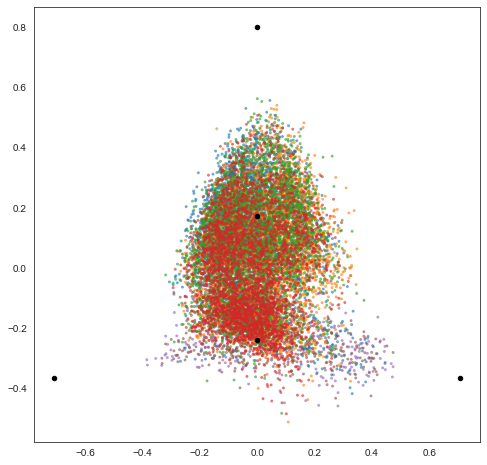

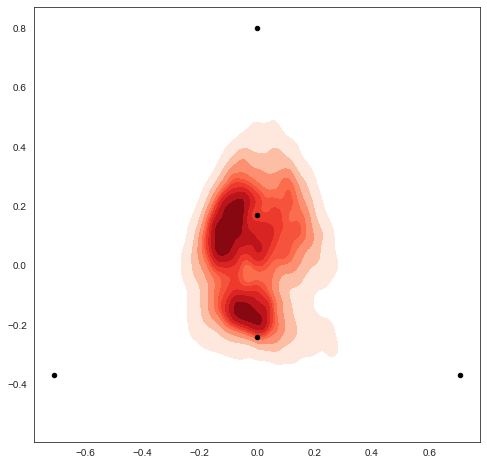

In [14]:
color_dict = {}
for i,c in enumerate(sorted(list(set(adata_small.obs['timepoint'])))):
    if i == 7:     color_dict[c] = sns.color_palette('tab10')[9] #skip grey
    else:
        color_dict[c] = sns.color_palette('tab10',8)[i]
cmap = 'jet'
_archetype_diagram_no_arrows(adata_small, color_dict=color_dict,color='timepoint',fname = 'RPM_archetype_space',
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',
                        multiplier=1, figsize=(8,8), score_name = '_Score', alpha = .5, s = 4, sizes = 20)


## Newer phenotype classification with labeled generalists
Let's check to see how many samples have significant scores (p>.3) for more than one phenotype.

<BarContainer object of 3 artists>

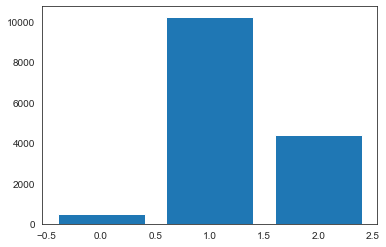

In [15]:
df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]
# np.unique((df > .3).sum(axis = 1), return_counts=True)[1]
plt.bar(height = np.unique(((df.T/df.sum(axis = 1)).T > .33).sum(axis = 1), return_counts=True)[1], x = range(3), log=False)

In [16]:
arc_pheno = []
arc_aa_type = []

for i,r in df.iterrows():
    r = r/r.sum()
    if (r > .33).sum() > 1:
        arc_aa_type.append('Generalist')
        arc_pheno.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])
    elif  (r > .33).sum() == 1:
        try:
            arc_aa_type.append(r.idxmax().split('_')[0]+" Specialist")
            arc_pheno.append(r.idxmax().split('_')[0])
        except AttributeError: 
            arc_aa_type.append("Unclassified")
            arc_pheno.append("Unclassified")
    else: 
        arc_aa_type.append("Unclassified")
        arc_pheno.append("Unclassified")
adata.obs['arc_pheno'] = arc_pheno
adata.obs['arc_aa_type'] = arc_aa_type


In [18]:
pd.crosstab(adata.obs['arc_pheno'],adata.obs['timepoint']).style.background_gradient(cmap='viridis')

In [19]:
pd.crosstab( adata.obs['arc_pheno'],adata.obs['Phenotype']).style.background_gradient(cmap='viridis')

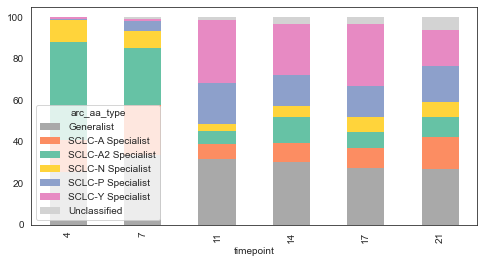

In [20]:
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(adata,groupby='timepoint', fname = 'RPM', pheno_name="arc_aa_type", custom_palette=color_dict)

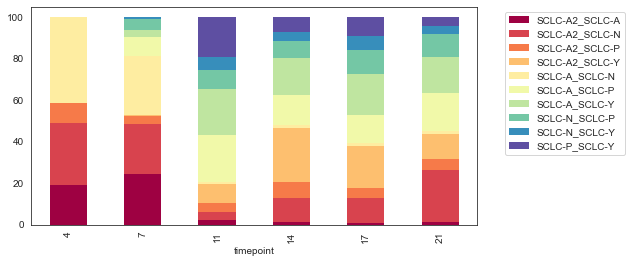

In [21]:
_adata = adata[adata.obs['arc_aa_type'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["timepoint"], _adata.obs['arc_pheno']).T /
  pd.crosstab(_adata.obs["timepoint"], _adata.obs['arc_pheno']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/arc_aa_generalist_subtypes.pdf')


In [21]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300
# mb.pl.archetype_diagrams(adata, sig_matrix, color_dict=color_dict, groupby='cline',color = 'arc_aa_type',
#                         order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',sizes = 20,
#                         figsize=(4,4), score_name = '_Score', alpha = .8, s = 8, arrows = False)


In [22]:
np.unique(adata.obs['arc_pheno'], return_counts=True)

(array(['SCLC-A', 'SCLC-A2', 'SCLC-A2_SCLC-A', 'SCLC-A2_SCLC-N',
        'SCLC-A2_SCLC-P', 'SCLC-A2_SCLC-Y', 'SCLC-A_SCLC-N',
        'SCLC-A_SCLC-P', 'SCLC-A_SCLC-Y', 'SCLC-N', 'SCLC-N_SCLC-P',
        'SCLC-N_SCLC-Y', 'SCLC-P', 'SCLC-P_SCLC-Y', 'SCLC-Y',
        'Unclassified'], dtype=object),
 array([1636, 1517,   99,  592,  240,  726,  111,  737,  827,  911,  422,
         226, 2456,  414, 3715,  509]))

In [23]:
adata.write_h5ad('../../out/RPM-time-series/adata_03.h5ad')



... storing 'Phenotype' as categorical
... storing 'arc_pheno' as categorical
... storing 'arc_aa_type' as categorical


# GMM Archetype Probabilities
CAP plots on GMM probabilities based on projection based archetype scores


In [ ]:
adata = sc.read_h5ad('../../out/RPM-time-series/adata_03.h5ad')


In [39]:
scores = adata.obs[[i for i in adata.obs.columns if '_Score_pos' in i]]


In [40]:
scores

SCLC-A_Score_pos  SCLC-A2_Score_pos  \
ID                                                                       
SRR11594440:AAAGGTAGTTGCAAGGx-0-4         -0.000000           0.566151   
SRR11594440:AACCACATCCACCTCAx-0-4         -0.000000           0.546932   
SRR11594440:AAGCGAGAGACCAGACx-0-4          0.059810           0.172874   
SRR11594440:AAGTACCGTTCGTACAx-0-4         -0.000000           0.795373   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4          0.054314           0.196318   
...                                             ...                ...   
SRR11594446:TTTGGTTCAAGATTGAx-21          -0.000000           0.064044   
SRR11594446:TTTGGTTCACGAAAGCx-21          -0.000000           0.237667   
SRR11594446:TTTGTTGAGCGACTGAx-21           0.011093           0.049094   
SRR11594446:TTTGTTGGTCTTGTCCx-21          -0.000000          -0.000000   
SRR11594446:TTTGTTGTCCCAAGTAx-21          -0.000000           0.118472   

                                   SCLC-N_Score_pos  SCLC-P_Score_pos  \
ID                                                                      
SRR11594440:AAAGGTAGTTGCAAGGx-0-4          0.085849          -0.00000   
SRR11594440:AACCACATCCACCTCAx-0-4          0.080143          -0.00000   
SRR11594440:AAGCGAGAGACCAGACx-0-4          0.328460          -0.00000   
SRR11594440:AAGTACCGTTCGTACAx-0-4          0.125540          -0.00000   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4          0.304650          -0.00000   
...                                             ...               ...   
SRR11594446:TTTGGTTCAAGATTGAx-21           0.104922          -0.00000   
SRR11594446:TTTGGTTCACGAAAGCx-21           0.197439          -0.00000   
SRR11594446:TTTGTTGAGCGACTGAx-21          -0.000000          -0.00000   
SRR11594446:TTTGTTGGTCTTGTCCx-21          -0.000000           0.01702   
SRR11594446:TTTGTTGTCCCAAGTAx-21           0.103798          -0.00000   

                                   SCLC-Y_Score_pos  
ID                                                   
SRR11594440:AAAGGTAGTTGCAAGGx-0-4         -0.000000  
SRR11594440:AACCACATCCACCTCAx-0-4         -0.000000  
SRR11594440:AAGCGAGAGACCAGACx-0-4         -0.000000  
SRR11594440:AAGTACCGTTCGTACAx-0-4         -0.000000  
SRR11594440:AAGTCGTTCGTAGGGAx-0-4         -0.000000  
...                                             ...  
SRR11594446:TTTGGTTCAAGATTGAx-21          -0.000000  
SRR11594446:TTTGGTTCACGAAAGCx-21          -0.000000  
SRR11594446:TTTGTTGAGCGACTGAx-21           0.299872  
SRR11594446:TTTGTTGGTCTTGTCCx-21          -0.000000  
SRR11594446:TTTGTTGTCCCAAGTAx-21          -0.000000  

[15138 rows x 5 columns]

In [91]:
# from sklearn.datasets import make_blobs
# from sklearn.mixture import GaussianMixture
# for n_samples in [50,100,500, 1000]:
#     centers = [(1, 0,0,0,0), (0,1,0,0, 0), (0,0,1,0,0), (0,0,0,1,0),(0,0,0,0,1)]
#     X, y = make_blobs(n_samples=n_samples, cluster_std = .1, centers=centers, shuffle=False, random_state=42)
#     gm = GaussianMixture(n_components=5)
#     gm.fit(pd.DataFrame(X,columns=scores.columns))
#     # scores.columns[pd.DataFrame(gm.means_).idxmax()]
#     proba = gm.predict_proba(scores)#[:,pd.DataFrame(gm.means_).idxmax()]
#     scv.pl.umap(X_magic, c = [proba[:,i] for i in range(5)], components='1,2', figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu', smooth = True)


# ParetoTI S Matrix
1. ParetoTI: fit_pch gives an S matrix for each archetype. Take a look at these values. Maybe try a Gaussian model on these values?
2. We could also do a test where we see if each bulk archetype is enriched for S values for each archetype, and if significant, align the archetypes that way. 
3. Try doing a CAP plot for the S matrix and for the GMM-transformed S matrix


In [155]:
S_matrix = pd.read_csv('../../out/RPM-time-series/ParetoTI/S.csv', index_col=0).T

In [156]:
S_matrix

1         2         3         4  \
SRR11594440:AAAGGTAGTTGCAAGGx-0-4  0.081593  0.000000  0.123574  0.794833   
SRR11594440:AACCACATCCACCTCAx-0-4  0.064553  0.000000  0.030021  0.905426   
SRR11594440:AAGCGAGAGACCAGACx-0-4  0.110960  0.000000  0.082349  0.161433   
SRR11594440:AAGTACCGTTCGTACAx-0-4  0.087077  0.000000  0.000000  0.912923   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4  0.105059  0.000000  0.075976  0.155997   
...                                     ...       ...       ...       ...   
SRR11594446:TTTGGTTCAAGATTGAx-21   0.044453  0.515906  0.384309  0.000000   
SRR11594446:TTTGGTTCACGAAAGCx-21   0.000000  0.747365  0.252635  0.000000   
SRR11594446:TTTGTTGAGCGACTGAx-21   0.000000  0.116700  0.095349  0.000610   
SRR11594446:TTTGTTGGTCTTGTCCx-21   0.181029  0.625517  0.193454  0.000000   
SRR11594446:TTTGTTGTCCCAAGTAx-21   0.000000  0.467348  0.000000  0.000000   

                                          5         6  
SRR11594440:AAAGGTAGTTGCAAGGx-0-4  0.000000  0.000000  
SRR11594440:AACCACATCCACCTCAx-0-4  0.000000  0.000000  
SRR11594440:AAGCGAGAGACCAGACx-0-4  0.645259  0.000000  
SRR11594440:AAGTACCGTTCGTACAx-0-4  0.000000  0.000000  
SRR11594440:AAGTCGTTCGTAGGGAx-0-4  0.662968  0.000000  
...                                     ...       ...  
SRR11594446:TTTGGTTCAAGATTGAx-21   0.001344  0.053987  
SRR11594446:TTTGGTTCACGAAAGCx-21   0.000000  0.000000  
SRR11594446:TTTGTTGAGCGACTGAx-21   0.000000  0.787341  
SRR11594446:TTTGTTGGTCTTGTCCx-21   0.000000  0.000000  
SRR11594446:TTTGTTGTCCCAAGTAx-21   0.025129  0.507523  

[15138 rows x 6 columns]

[<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>]

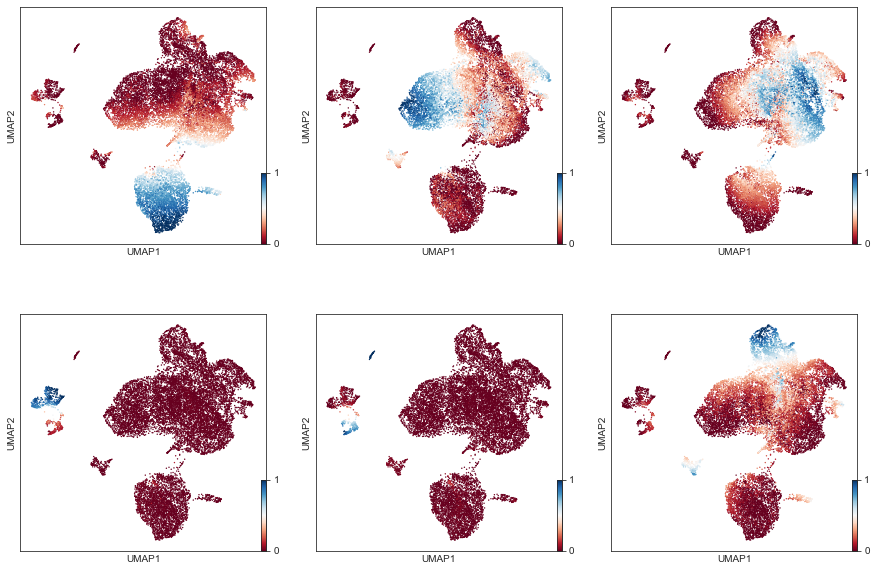

In [159]:
scv.pl.umap(X_magic, c = [S_matrix[i] for i in [1,2,3,4,5,6]], components='1,2', show=False, figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu')


In [229]:
X_magic.obsm['ParetoTI_S'] = S_matrix

In [251]:
tmp = X_magic.obsm['ParetoTI_S'].copy()

for arc in  X_magic.obsm['ParetoTI_S'].columns:
    closest = X_magic.obsm['ParetoTI_S'].loc[X_magic.obsm['ParetoTI_S'][arc].sort_values(ascending = False) > .8]
    tmp.loc[closest.index,'specialist'] = arc
X_magic.obs['specialists_ParetoTI_S'] = tmp.specialist
X_magic.obs['specialists_ParetoTI_S'].value_counts()

1    1501
2     831
3     568
4     363
6     304
5      89
Name: specialists_ParetoTI_S, dtype: int64

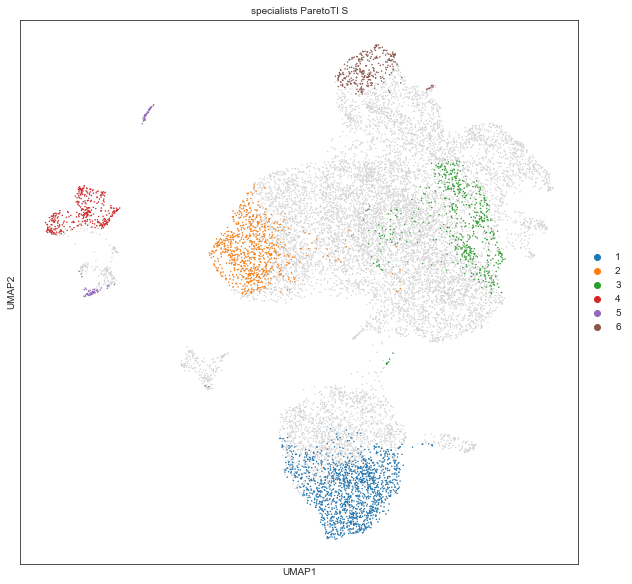

In [252]:
scv.pl.umap(X_magic, color = 'specialists_ParetoTI_S', figsize= (10,10), frameon=True, legend_loc = 'on right')


In [210]:
arc_dist = pd.read_csv('../../out/RPM-time-series/ParetoTI/distances.csv', header=0, index_col=1)
arc_dist = arc_dist.drop('Unnamed: 0', axis = 1)
arc_dist.head()

archetype_1  archetype_2  archetype_3  \
sample_id                                                                  
SRR11594440:AAAGGTAGTTGCAAGGx-0-4    86.780977    77.590983    77.465796   
SRR11594440:AACCACATCCACCTCAx-0-4    93.774124    86.504348    85.469965   
SRR11594440:AAGCGAGAGACCAGACx-0-4    80.793297    74.325123    71.204724   
SRR11594440:AAGTACCGTTCGTACAx-0-4    92.859427    89.725171    87.128770   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4    81.743490    75.385192    72.203243   

                                   archetype_4  archetype_5  archetype_6  
sample_id                                                                 
SRR11594440:AAAGGTAGTTGCAAGGx-0-4    43.001142    91.556495    92.695232  
SRR11594440:AACCACATCCACCTCAx-0-4    34.259771    93.427149    99.423326  
SRR11594440:AAGCGAGAGACCAGACx-0-4    75.386097    50.430990    92.097825  
SRR11594440:AAGTACCGTTCGTACAx-0-4    31.452879    90.358241   104.567018  
SRR11594440:AAGTCGTTCGTAGGGAx-0-4    75.769277    49.224710    92.981948

In [211]:
X_magic.obsm['ParetoTI_arc_distance'] = arc_dist

In [212]:
X_magic.obsm['ParetoTI_arc_distance'].min()

archetype_1    17.595075
archetype_2     8.432306
archetype_3    10.075987
archetype_4    19.700669
archetype_5    26.336753
archetype_6    13.386581
dtype: float64

In [221]:
tmp = X_magic.obsm['ParetoTI_arc_distance'].copy()

# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  X_magic.obsm['ParetoTI_arc_distance'].columns:
    closest = X_magic.obsm['ParetoTI_arc_distance'].loc[X_magic.obsm['ParetoTI_arc_distance'][arc].sort_values() < 30]
    tmp.loc[closest.index,'specialist'] = arc


X_magic.obs['specialists_pca_diffdist_ParetoTI'] = tmp.specialist

In [223]:
X_magic.obs['specialists_pca_diffdist_ParetoTI'].value_counts()

archetype_3    5059
archetype_2    4562
archetype_1    1625
archetype_6     495
archetype_4     159
archetype_5       5
Name: specialists_pca_diffdist_ParetoTI, dtype: int64

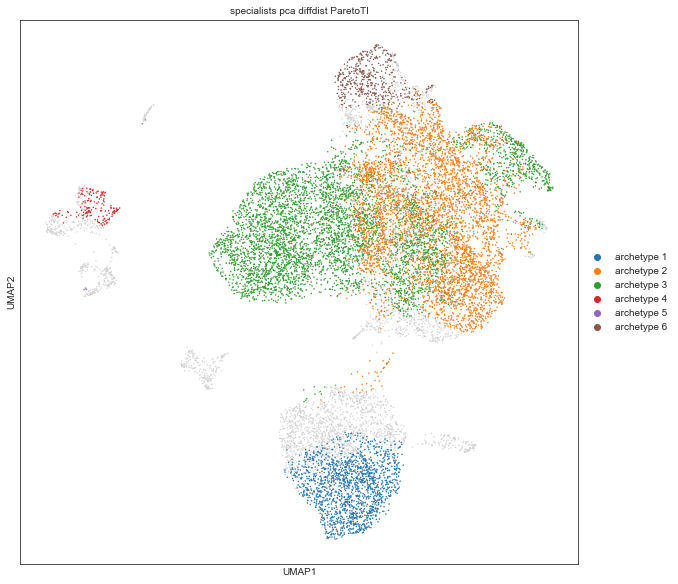

In [224]:
scv.pl.umap(X_magic, color = 'specialists_pca_diffdist_ParetoTI', figsize= (10,10), frameon=True, legend_loc = 'on right')


In [226]:
pd.crosstab(X_magic.obs.specialists_pca_diffdist_ParetoTI, X_magic.obs.timepoint).style.background_gradient('viridis')

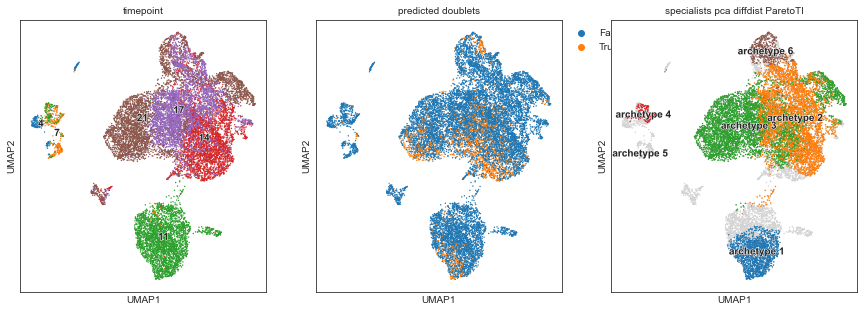

In [248]:
scv.pl.umap(X_magic, c = ['timepoint','predicted_doublets','specialists_pca_diffdist_ParetoTI'], components='1,2', figsize= (5,5), frameon=True, cmap = 'RdBu')


In [98]:
X_magic.obs = pd.merge(adata.obs.arc_aa_type,X_magic.obs, left_index=True, right_index=True)

In [109]:
X_magic.obs = pd.merge(adata.obs[[i for i in adata.obs if '_Score_pos' in i]],X_magic.obs, left_index=True, right_index=True)

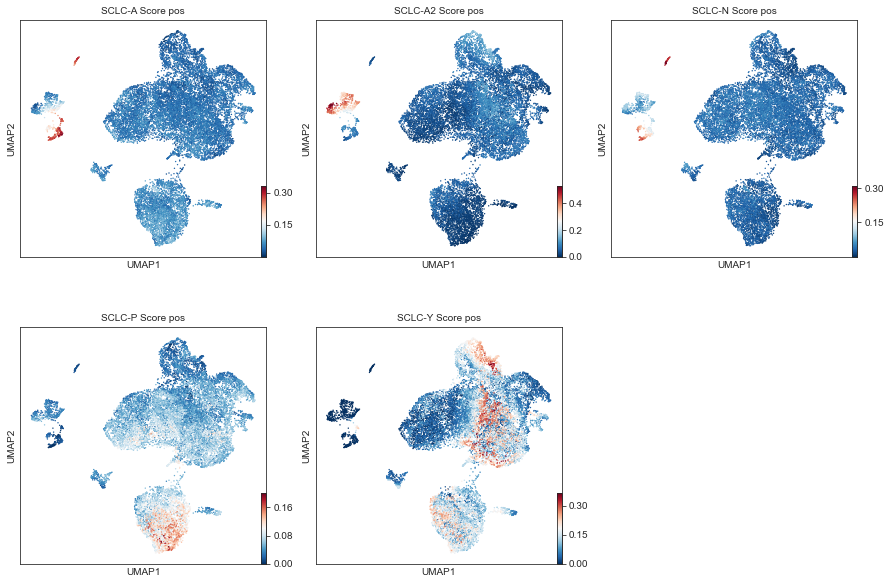

In [397]:
scv.pl.umap(X_magic, color = [i for i in adata.obs.columns if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,5), frameon=True,
            ncols = 3, smooth = True)

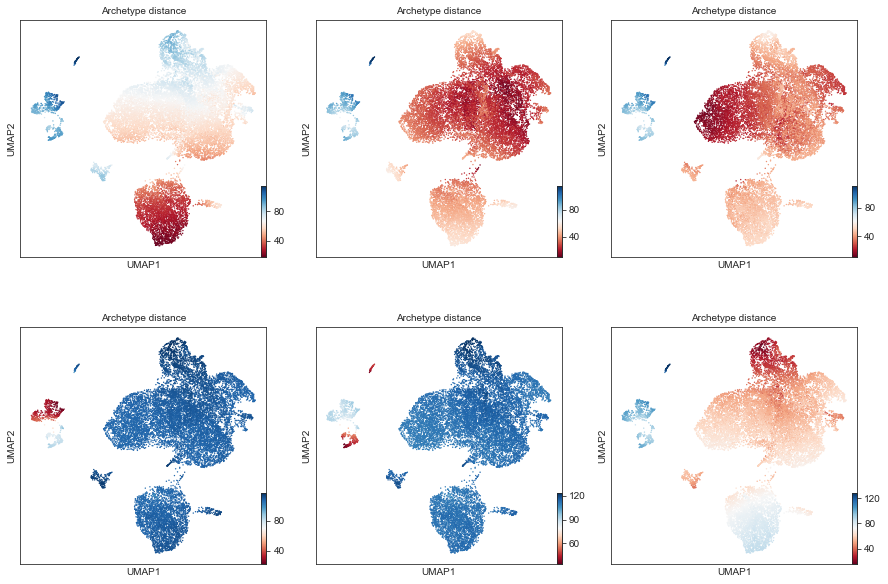

In [357]:
scv.pl.umap(X_magic, color = [X_magic.obsm['ParetoTI_arc_distance'][i] for i in X_magic.obsm['ParetoTI_arc_distance']], legend_loc = 'on right', cmap='RdBu',
            figsize= (5,5), frameon=True,
            ncols = 3, smooth = True, title = "Archetype distance")

In [241]:
X_magic.obsm['ParetoTI_S'].columns = X_magic.obsm['ParetoTI_S'].columns.astype(str)


[<AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>]

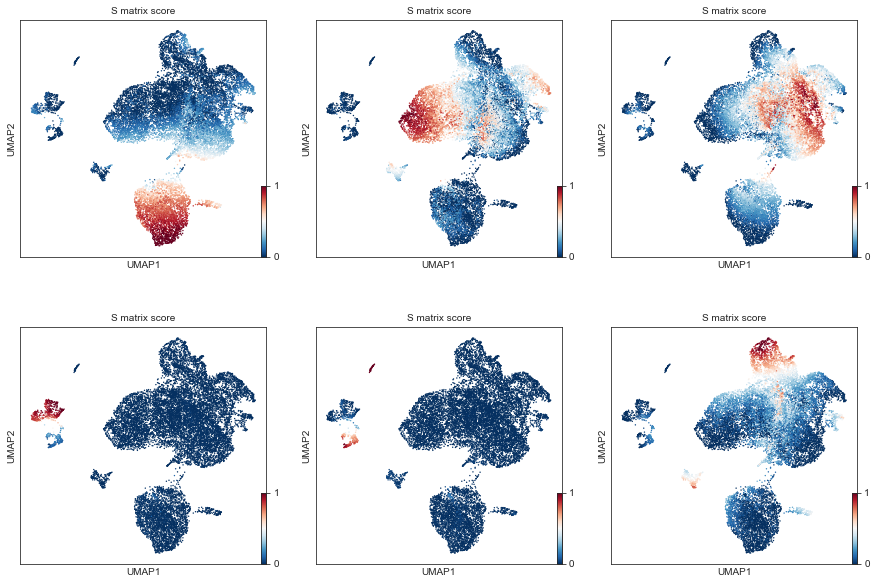

In [358]:
scv.pl.umap(X_magic, c = [X_magic.obsm['ParetoTI_S'][i] for i in X_magic.obsm['ParetoTI_S']], components='1,2', show=False, figsize= (5,5),ncols = 3, 
            title = 'S matrix score',
            frameon=True, cmap = 'RdBu_r')


In [227]:
adata.write_h5ad('../../out/RPM-time-series/adata_03b.h5ad')

In [242]:
X_magic.write_h5ad('../../out/RPM-time-series/X_magic_03b.h5ad')

## Enrichment of bulk archetype signatures using Permutation enrichment test

We want to follow the same pipeline as ParTI enrichment, so we need:
1. Distances to each archetype, to determine which bin to put cells into
2. Score for each cell that we want to test enrichment of (i.e. each signature score)
    1. We may want a cut-off of significance for the scores first (or a z score, for example), so that you can't get enrichment of insignificant scores
    2. For example, P may be "enriched" in one of the archetypes, but if the P score itself isn't significant, then its enrichment doesn't mean much.
3. We want to use  a Mann-Whitney test (with FDR corrected q < 0.1). We should split the data into 10 bins and test enrichment of the clsoest bin vs. the rest of the data. The closest bin should also be the maximum.

We want to make sure we sample cells from each timepoint to make sure we are sampling from the whole space (e.g. A and A2 are enriched in a lot just because A and A2 are undersampled, so the background distribution isn't biased)

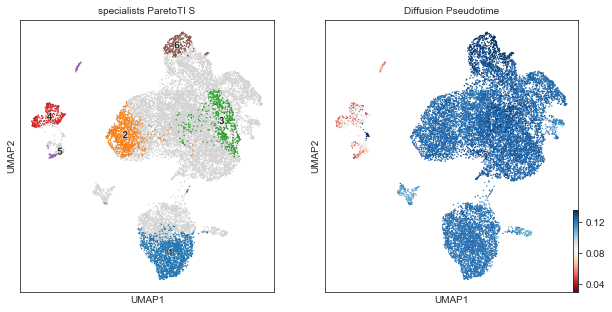

In [555]:
scv.pl.umap(X_magic, c = ['specialists_ParetoTI_S','Diffusion Pseudotime'], components='1,2', figsize= (5,5), frameon=True, cmap = 'RdBu')


saving figure to file ./figures/scvelo_bulk_score_umaps.png


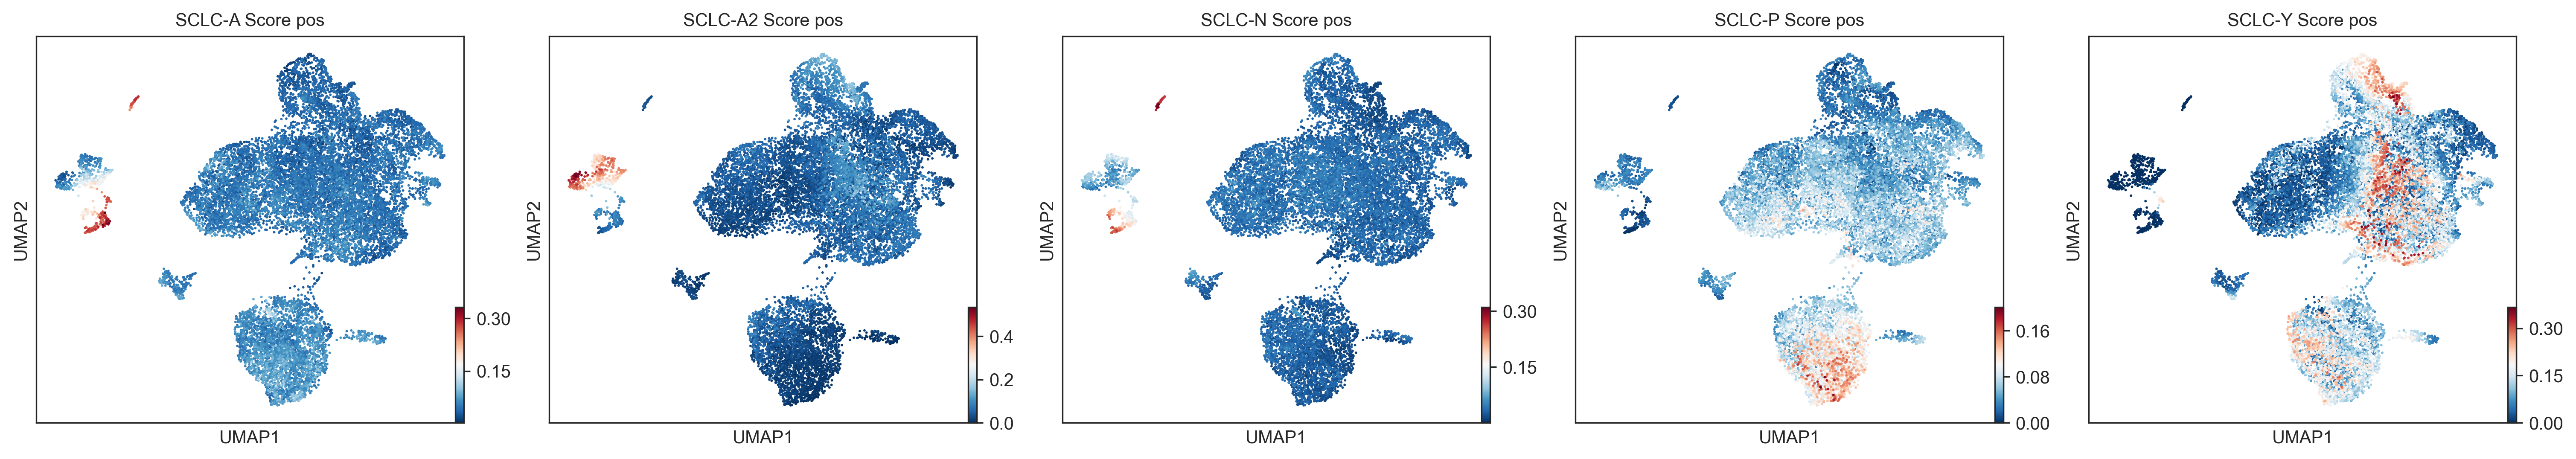

In [32]:
scv.pl.umap(X_magic, color = [i for i in X_magic.obs.columns if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,4), frameon=True, dpi = 300,
            ncols = 5, smooth = True, save = 'bulk_score_umaps.png')

In [55]:
X_magic.write_h5ad('../../out/RPM-time-series/X_magic_03b.h5ad')

In [565]:
X_magic

AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_aa_type', 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist', 'specialists_pca_diffdist_ParetoTI', 'specialists_ParetoTI_S'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'neighbors', 'pca', 'specialists_pca_diffdist_colors', 'timepoint_colors', 'umap', 'arc_aa_type_colors', 'predicted_doublets_colors', 'specialists_pca_diffdist_ParetoTI_colors', 'specialists_ParetoTI_S_colors'
    obsm: 'X_pca', 'X_umap', 'arc_distance', 'py_pcha_S', 'ParetoTI_arc_di

In [3]:
X_magic = sc.read_h5ad('../../out/RPM-time-series/X_magic_03b.h5ad')

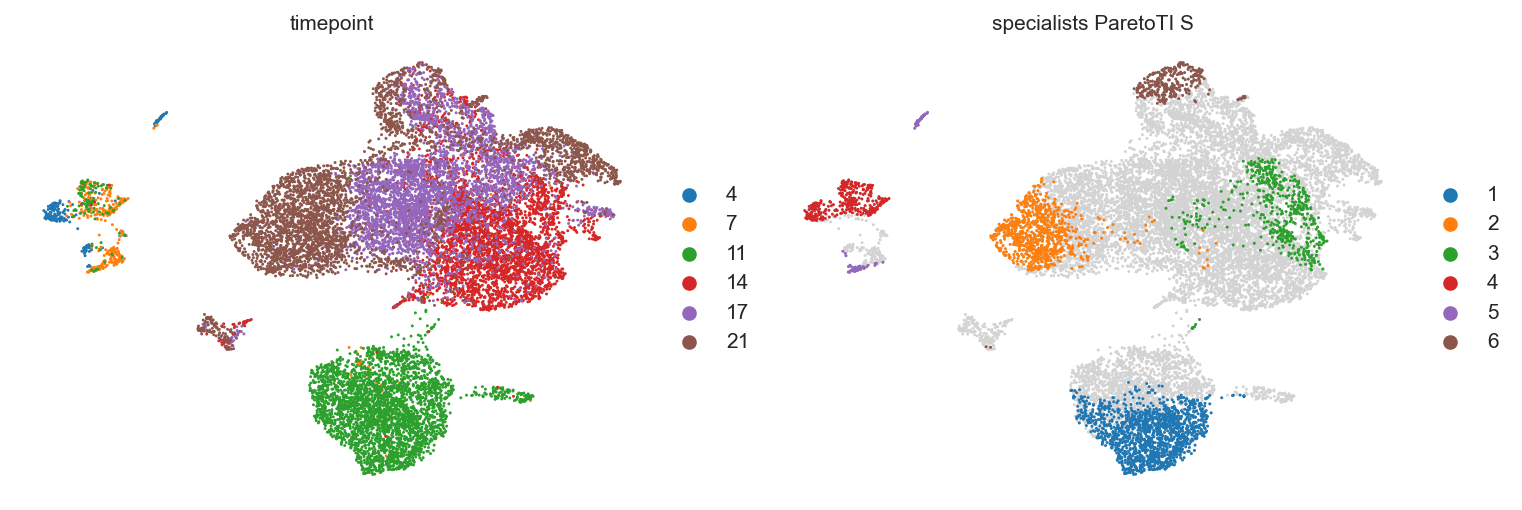

In [6]:
scv.pl.umap(X_magic, color = ['timepoint','specialists_ParetoTI_S'], legend_loc = 'on right', dpi = 150)

Archetype: 1


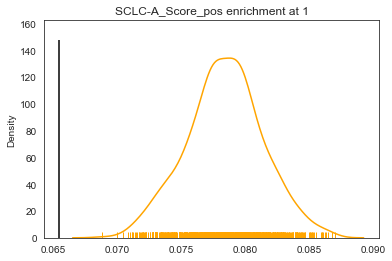

	 p-value for SCLC-A_Score_pos: 1.0


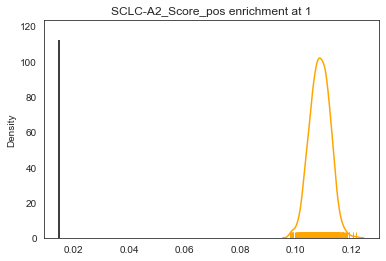

	 p-value for SCLC-A2_Score_pos: 1.0


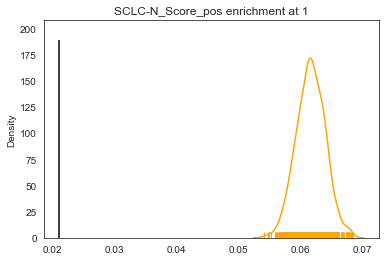

	 p-value for SCLC-N_Score_pos: 1.0


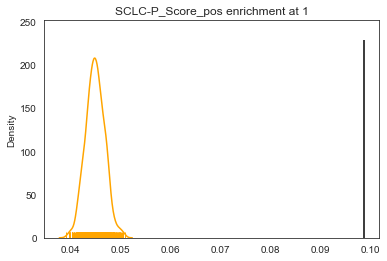

	 p-value for SCLC-P_Score_pos: 0.0


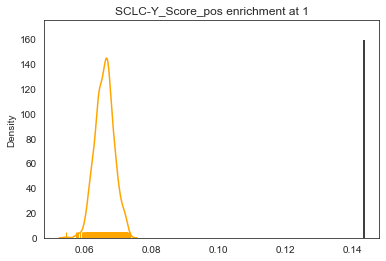

	 p-value for SCLC-Y_Score_pos: 0.0
Archetype: 2


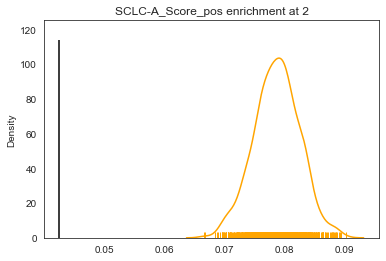

	 p-value for SCLC-A_Score_pos: 1.0


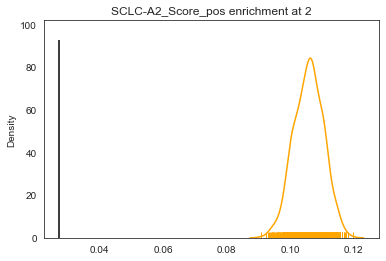

	 p-value for SCLC-A2_Score_pos: 1.0


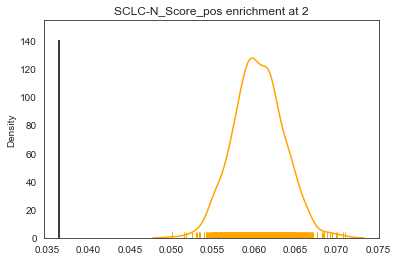

	 p-value for SCLC-N_Score_pos: 1.0


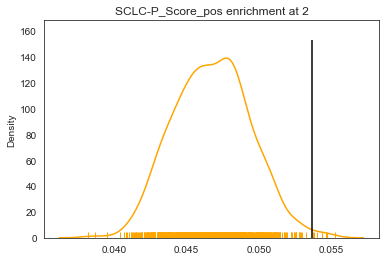

	 p-value for SCLC-P_Score_pos: 0.008000000000000007


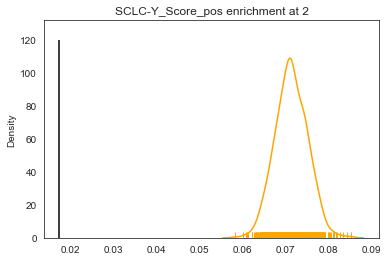

	 p-value for SCLC-Y_Score_pos: 1.0
Archetype: 3


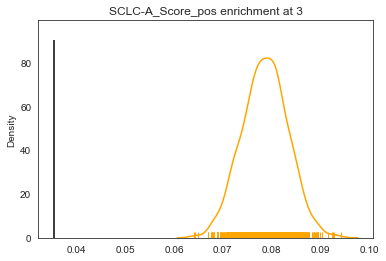

	 p-value for SCLC-A_Score_pos: 1.0


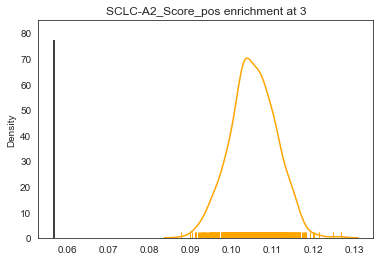

	 p-value for SCLC-A2_Score_pos: 1.0


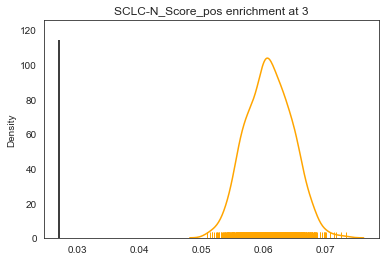

	 p-value for SCLC-N_Score_pos: 1.0


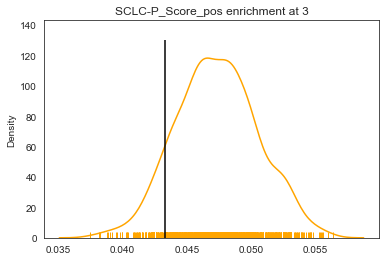

	 p-value for SCLC-P_Score_pos: 0.906


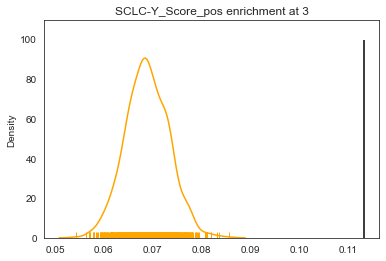

	 p-value for SCLC-Y_Score_pos: 0.0
Archetype: 4


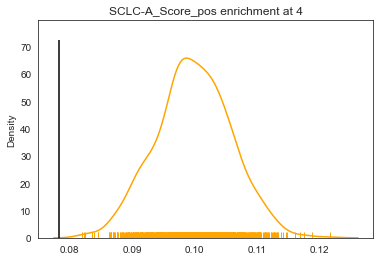

	 p-value for SCLC-A_Score_pos: 1.0


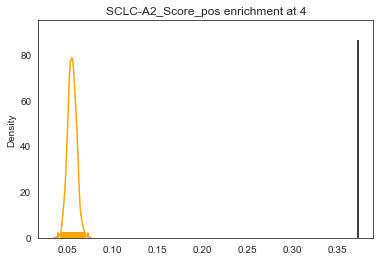

	 p-value for SCLC-A2_Score_pos: 0.0


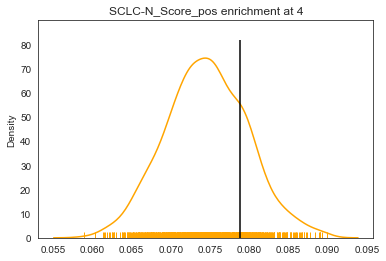

	 p-value for SCLC-N_Score_pos: 0.21700000000000008


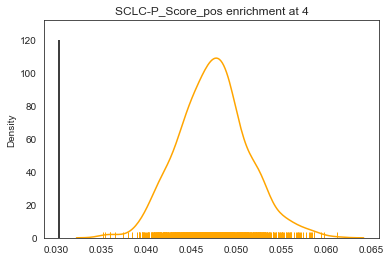

	 p-value for SCLC-P_Score_pos: 1.0


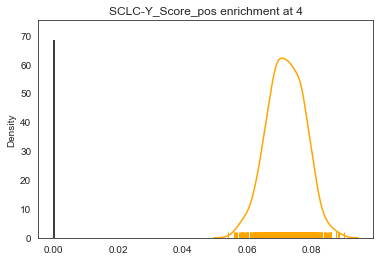

	 p-value for SCLC-Y_Score_pos: 1.0
Archetype: 5


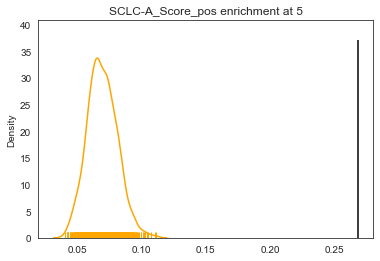

	 p-value for SCLC-A_Score_pos: 0.0


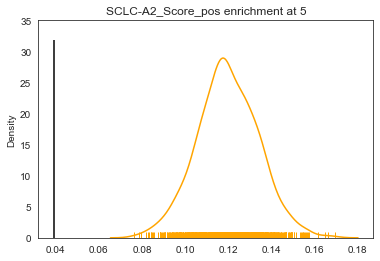

	 p-value for SCLC-A2_Score_pos: 1.0


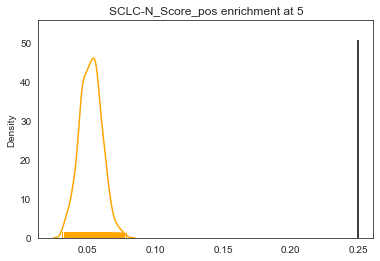

	 p-value for SCLC-N_Score_pos: 0.0


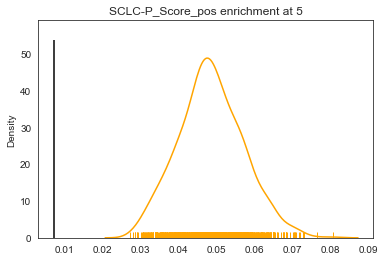

	 p-value for SCLC-P_Score_pos: 1.0


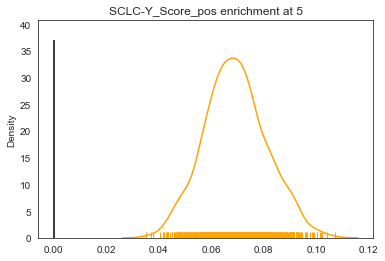

	 p-value for SCLC-Y_Score_pos: 1.0
Archetype: 6


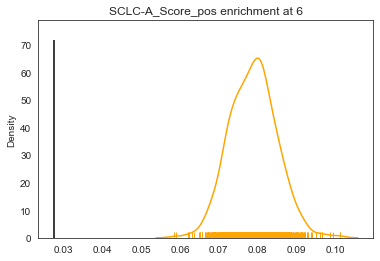

	 p-value for SCLC-A_Score_pos: 1.0


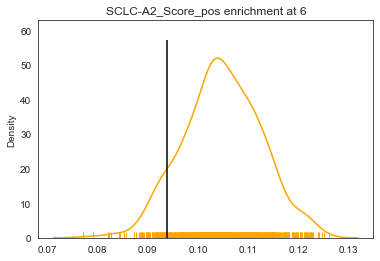

	 p-value for SCLC-A2_Score_pos: 0.913


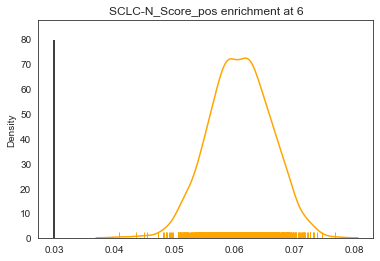

	 p-value for SCLC-N_Score_pos: 1.0


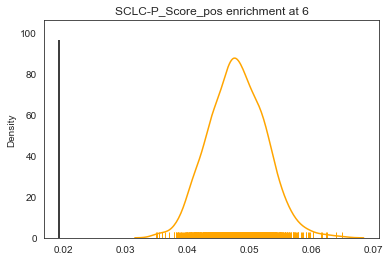

	 p-value for SCLC-P_Score_pos: 1.0


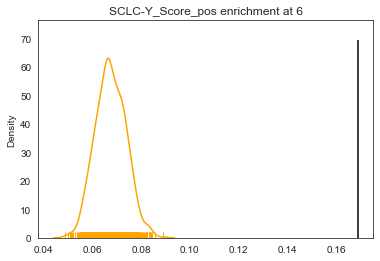

	 p-value for SCLC-Y_Score_pos: 0.0


In [4]:
score = X_magic.obs[[i for i in X_magic.obs if '_Score_pos' in i]]
score = score.fillna(0)
p_values_mean_SE = mb.ar.permutation_enrichment_test(X_magic, score, plot = True, stat = 'mean', verbose = False, sample_equally='timepoint')

In [20]:
#now implemented in permutation_enrichment_test
from statsmodels.stats import multitest
p_values_mean_SE['id'] = p_values_mean_SE.index
p_values_mean_SE_melt = p_values_mean_SE.melt(id_vars='id',value_vars=p_values_mean_SE.columns)
p_values_mean_SE_melt['corr_p'] = multitest.multipletests(p_values_mean_SE_melt['value'], method = 'holm')[1]

In [23]:
p_values_mean_SE_melt.pivot(index='id', columns='variable', values='corr_p')

variable SCLC-A2_Score_pos SCLC-A_Score_pos SCLC-N_Score_pos SCLC-P_Score_pos  \
id                                                                              
1                        1                1                1              0.0   
2                        1                1                1            0.184   
3                        1                1                1                1   
4                      0.0                1                1                1   
5                        1              0.0              0.0                1   
6                        1                1                1                1   

variable SCLC-Y_Score_pos  
id                         
1                     0.0  
2                       1  
3                     0.0  
4                       1  
5                       1  
6                     0.0

In [29]:
 X_magic.obs['ParetoTI_specialists'] = [{'1':'P/Y',
 '2':'None',
 '3':'Y',
 '4':'A2',
 '5':'A/N',
 '6':'Y',
 np.nan: np.nan}[i] for i in X_magic.obs.specialists_ParetoTI_S]
    

In [43]:
X_magic.obs.ParetoTI_specialists.cat.categories

Index(['A/N', 'A2', 'None', 'P/Y', 'Y'], dtype='object')

In [53]:
X_magic.uns['ParetoTI_specialists_colors'] = ['#F8766D','#E18A00','#BE9C00','#8CAB00','#24B700']



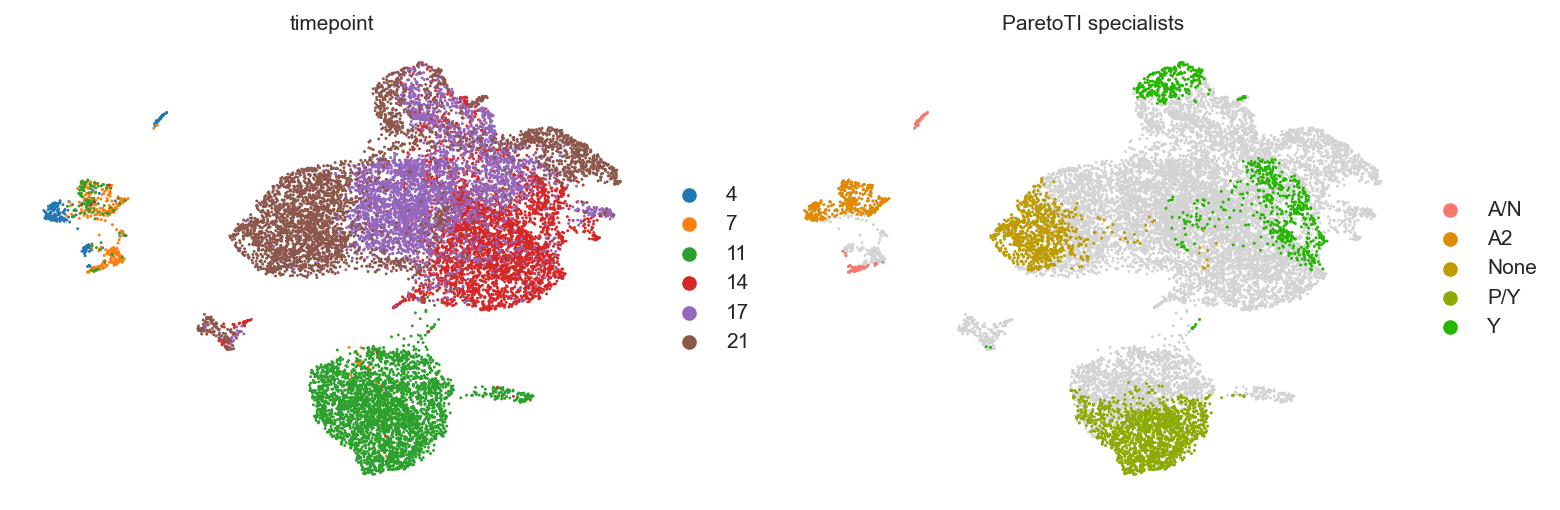

In [54]:
scv.pl.umap(X_magic, color = ['timepoint','ParetoTI_specialists'], legend_loc = 'on right', dpi = 150)



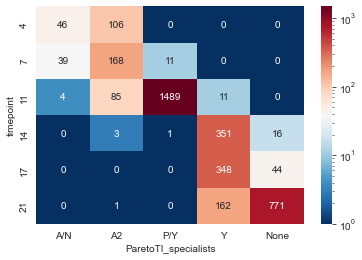

In [80]:
from matplotlib.colors import LogNorm, Normalize

sns.heatmap(pd.crosstab(X_magic.obs.timepoint, X_magic.obs.ParetoTI_specialists)[['A/N','A2','P/Y','Y','None']], annot=True,
            norm=LogNorm(clip = True), fmt = 'd', cmap = 'RdBu_r')
plt.savefig('./figures/heatmap_ParetoTI-specialists_timepoints.pdf')


In [55]:
X_magic.write_h5ad('../../out/RPM-time-series/X_magic_03b.h5ad')


In [92]:
X_magic.obs['subtype'] =X_magic.obs.specialists_ParetoTI_S

X_magic.obs.subtype = [str(i) for i in X_magic.obs.subtype]

new = []
for i in X_magic.obs.subtype:
    if i == 'nan':
        new.append("Generalist")
    else:
        new.append("Archetype "+str(i))

X_magic.obs.subtype = new

In [115]:
X_magic.obs['subtype_labeled'] =X_magic.obs.ParetoTI_specialists

X_magic.obs.subtype_labeled = [str(i) for i in X_magic.obs.subtype_labeled]

new = []
for i in X_magic.obs.subtype_labeled:
    if i == 'nan':
        new.append("Generalist")
    else:
        new.append(str(i))

X_magic.obs.subtype_labeled = new

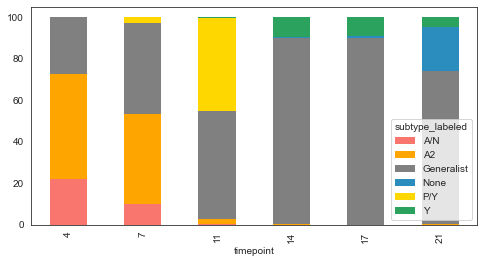

In [129]:
# cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
# color_dict = {'Archetype 3': cp[4], 'Archetype 5': cp[0], 'Archetype 4': cp[1], 'Archetype 2': cp[2], 'Archetype 1': cp[3],
#               'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(X_magic,groupby='timepoint', fname = 'RPM', pheno_name="subtype_labeled", custom_palette=['#F8766D','orange','grey','#2b8cbe','gold','#2ca25f'])

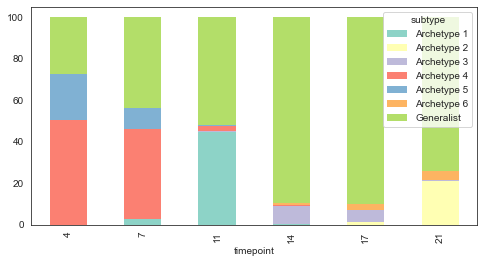

In [130]:
mb.pl.subtype_bar(X_magic,groupby='timepoint', fname = 'RPM_labeled', pheno_name="subtype", custom_palette=sns.color_palette('Set3',7))

## Cap Plots

In [143]:
from itertools import permutations

# for a specific set of endpoints:
# arrange endpoints evenly around a circle (i.e. with angles a_k) for each k
# calculare x_i and y_i for each datapoint
# plot in cartesian coordinates
def proximity(probabilities):
    #for each pair of arcs, calculate proximity as sum of cross product 
    #list of pairs in order
    l = [[i,i+1] for i in range(len(probabilities.columns)-1)]
    l.append([len(probabilities.columns)-1, 0])
    best_dlk = 0
    best_perm = None
    for perm in list(permutations(probabilities.columns,len(probabilities.columns))):
        d_lk = 0
        for pair in l:
            # print(np.dot(probabilities[perm[pair[0]]], probabilities[perm[pair[1]]]))
            d_lk += np.dot(probabilities[perm[pair[0]]], probabilities[perm[pair[1]]])
        if d_lk > best_dlk:
            best_dlk = d_lk
            best_perm = perm
    return best_dlk, best_perm
        
def cap_plot(probabilities, hue = None, arc_hue_dict = None, plot_type = 'scatterplot', fill = False, levels = 10):
    probabilities = probabilities.dropna()

    n_arcs = len(probabilities.columns)

    best_dlk, best_perm = proximity(probabilities)
    # single assignment
    
    angles = np.linspace(0,360, n_arcs, endpoint=False)
    # assign arcs to angles
    print(best_perm)
    ang_dict = {i:k for i,k in zip(best_perm, angles)}
    # given assignment, project probabilities to cartesian coordinates
    # each data point
    # x_i
    x = [probabilities[list(best_perm)].loc[i].dot(np.cos(np.radians([ang_dict[o] for o in best_perm]))) for i,r in probabilities.iterrows()]
    #y_i
    y = [probabilities[list(best_perm)].loc[i].dot(np.sin(np.radians([ang_dict[o] for o in best_perm]))) for i,r in probabilities.iterrows()]
    
    
    #archetype locations
    x_arc = np.cos(np.radians([ang_dict[o] for o in best_perm]))
    y_arc = np.sin(np.radians([ang_dict[o] for o in best_perm]))
    
    plt.figure(figsize = (10,10))
    if plot_type == 'scatterplot':
        sns.scatterplot(x,y, s =60, alpha = .5, hue = hue.loc[probabilities.index])
        sns.scatterplot(x_arc,y_arc, s = 100, c = [arc_hue_dict[i] for i in best_perm])
    elif plot_type == 'kde':
        sns.scatterplot(x_arc,y_arc, s = 100, c = [arc_hue_dict[i] for i in best_perm])
        sns.kdeplot(x,y, hue = hue.loc[probabilities.index], alpha = 0.5, fill = fill, levels = levels)

    plt.show()
    return best_perm

('1', '4', '5', '6', '2', '3')


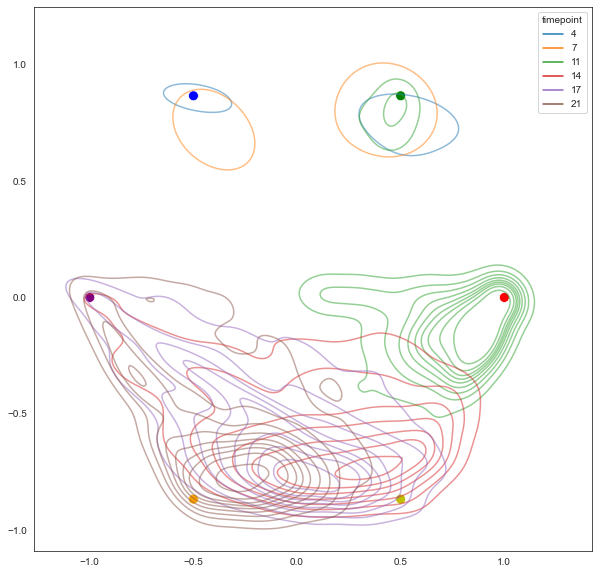

('1', '4', '5', '6', '2', '3')

In [244]:
cap_plot(pd.DataFrame(X_magic.obsm['ParetoTI_S'], index = X_magic.obs_names),hue = X_magic.obs.timepoint,plot_type='kde', 
         arc_hue_dict={str(i+1):j for i,j in enumerate(['r','orange','y','g','b','purple'])})

('1', '4', '5', '6', '2', '3')


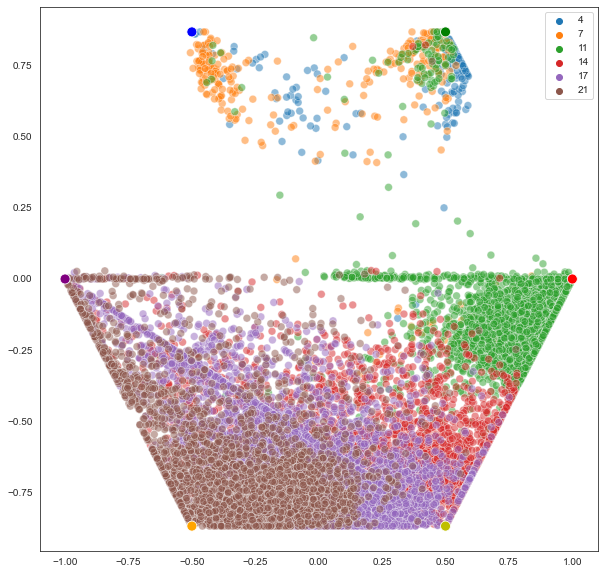

('1', '4', '5', '6', '2', '3')

In [245]:
cap_plot(pd.DataFrame(X_magic.obsm['ParetoTI_S'], index = X_magic.obs_names),hue = X_magic.obs.timepoint,plot_type='scatterplot', 
         arc_hue_dict={str(i+1):j for i,j in enumerate(['r','orange','y','g','b','purple'])})

('1', '4', '5', '6', '2', '3')


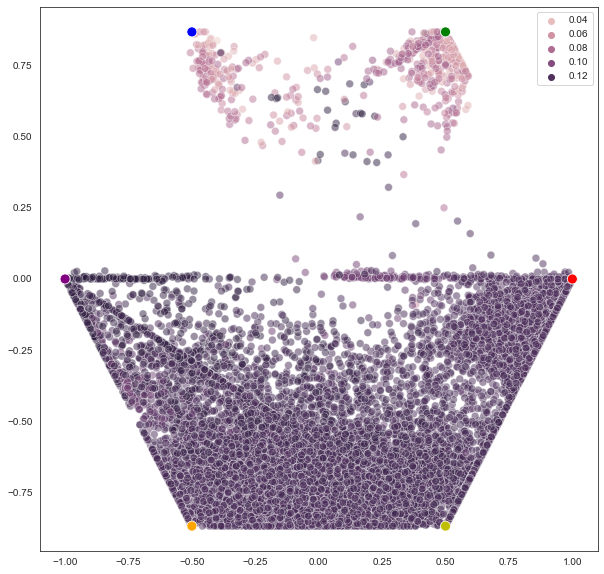

('1', '4', '5', '6', '2', '3')

In [247]:
cap_plot(pd.DataFrame(X_magic.obsm['ParetoTI_S'], index = X_magic.obs_names),hue = X_magic.obs['Diffusion Pseudotime'],plot_type='scatterplot', 
         arc_hue_dict={str(i+1):j for i,j in enumerate(['r','orange','y','g','b','purple'])})

# What's driving the signal for each signature?

In [556]:
adata_small

AnnData object with n_obs × n_vars = 15138 × 85
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist', 'SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-N_Score', 'SCLC-A2_Score', 'SCLC-A_Score', 'Phenotype', 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'clusters_gradients_colors', 'neighbors', 'pca', 'phase_colors', 'predicted_doublets_colors', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_pca_imputed'
    varm: 'PCs'
    layers: 'ambiguous', 'log1p_norm_unscaled', 'matrix', 'norm_counts', 'spliced', 'unsp